# Exercise 4

Create a visualization of the provided sheep data. You may create either an adjacency matrix visualization, or a node-link visualization.

- Data - sheep_data.zip, sheep_ml.graphml
- Tools - Python NetworkX reccomended, D3 force layout may also be used (for node-link visualization).
- Report - Up to 3 pages (anything beyond three pages will not be graded). Discuss the expressiveness and effectiveness of your chosen visual idiom. Describe any findings that can be identified or learned from the visualization. See report format
- Notes - The edge weights are non-symmetric, meaning that the network has directed edges. You are NOT required to visualize the weights on both directions of each edge as this can get very complicated (specifically with node-link visualizations). You are allowed to simply pick one value for each edge.
- Grading - Since implementing interativity with NetworkX solutions is a significant challenge, for NetworkX solutions without interactivity, interactivity points will be awarded in one of two ways: If the data is augmented (i.e. extra properties of the data are computed and used for visualization) the interactivity portion of the grade will be assigned to the expressiveness and effectiveness of the visualization of this augmentation (please also discuss the augmentation in your report).<br>Otherwise, the interactivity points will be evenly split between the effectiveness and report sections (making them 40% and 30% respectively). This means if you choose not to use interactivity or augmentation, please put extra attention into your report and the justification of the effectiveness of the choices you made in your visualization.
- Due Date - Feb 20th, 1am PT Refer to submission instructions

## Explore the Dataset

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

In [29]:
with open('Data/sheep_data/README.txt') as f:
    print(f.read())

DSE 241: Exercise 4 Data

HAAS -- BIGHORN SHEEP DOMINANCE

Source: http://moreno.ss.uci.edu/data.html#sheep

Description: 
    - sheep_age.csv:  
        - Two Columns: Sheep_ID, Sheep_Age
    - sheep_edges.csv: 
        - Three Columns: Source_Sheep_ID, Target_Sheep_ID, Weight

Background:
    Data record wins and losses for 28 female bighorn sheep observed on the National Bison Range in 1984. The 'Weight' entry is the number of occasions on which the Source sheep was observed dominating the Target sheep. Ages are listed, but those assigned an age of 9 are at least 9 years old; they may be older.

Reference:
    Christine Hass, "Social status in female bighorn sheep (Ovis canadensis): expression, development and reproductive correlates." Journal of the Zoological Society of London, 1991, 225: 509-523.Station, Technical Bulletin 73. 


In [30]:
age_df = pd.read_csv('Data/sheep_data/sheep_age.csv')
edges_df = pd.read_csv('Data/sheep_data/sheep_edges.csv')

In [31]:
print('Number of entries in the "age" dataset: ',len(age_df))
age_df.head()

Number of entries in the "age" dataset:  28


,id,age
0,1,8
1,2,8
2,3,4
3,4,7
4,5,8


In [105]:
print('Number of entries in the "edges" dataset: ',len(edges_df))
edges_df.head(10)

Number of entries in the "edges" dataset:  250


,source,target,weight
0,1,2,1
1,1,3,1
2,1,4,1
3,1,5,1
4,1,6,1
5,7,8,5
6,7,9,2
7,7,10,1
8,7,3,4
9,7,11,1


In [115]:
df = edges_df.groupby(['source']).size().reset_index(name='dominations')
df = df.rename(columns={'source':'id'})
df.head()

,id,dominations
0,1,5
1,2,14
2,3,18
3,4,17
4,5,2


In [117]:
df_new = df.merge(age_df, on='id', how='inner')
df_new.head()

,id,dominations,age
0,1,5,8
1,2,14,8
2,3,18,4
3,4,17,7
4,5,2,8


## Generate Graph using NetworkX

In [121]:
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

In [122]:
# Initialize the graph
G = nx.DiGraph()
#G = nx.Graph()

In [123]:
# Generate Dictionary with Sheep ID and Age
nodes_list = []
for i,age in zip(age_df['id'],age_df['age']):
    nodes_list.append((i, {"age": age}))

In [124]:
# Generate Dictionary with Edges with values Source - Target - Weight
edges_list = []
for s,t,w in zip(edges_df['source'],edges_df['target'],edges_df['weight']):
    edges_list.append((s,t,{"weight": w}))

In [125]:
# Add Nodes and Edges to the Graph
G.add_nodes_from(nodes_list)
G.add_weighted_edges_from(edges_list)

In [127]:
pos = nx.circular_layout(G)
#pos = nx.spring_layout(G,iterations=50)

In [130]:
weight_list = []
for edge in G.edges():
    weight_list.append(G.get_edge_data(edge[0],edge[1])['weight']['weight'])

In [137]:
# Get the number of dominations
dom_size = list(df_new['dominations'])

In [143]:
# Get a list of the Age of each sheep.
age_list = list(df_new['age'])

In [194]:
import plotly.graph_objects as go

edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)
    
edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

node_x = []
node_y = []
for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    textposition='top center',
    marker=dict(
        showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='Earth',
        reversescale=True,
        color=[],
        size=dom_size,
        colorbar=dict(
            thickness=15,
            title='Dominance Count',
            xanchor='left',
            titleside='right'
        ),
        line_width=1))

In [195]:
node_adjacencies = []
node_text = []
for node, adjacencies in enumerate(G.adjacency()):
    node_adjacencies.append(len(adjacencies[1]))
    node_text.append('Dominance Count: '+ str(len(adjacencies[1])) + '<br>Age: '+ str(50))

node_trace.marker.color = node_adjacencies
node_trace.text = node_text

In [196]:
node_adjacencies = []
node_text = []
for node, adjacencies in enumerate(G.adjacency()):
    node_adjacencies.append(len(adjacencies[1]))
    node_text.append('Dominance Count: '+ str(len(adjacencies[1])) + '<br>Age: '+ str(G.nodes[node+1]['age']))
node_trace.marker.color = node_adjacencies
node_trace.text = node_text

In [197]:
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='HAAS--BIGHORN SHEEP DOMINANCE',
                title_x=0.45,
                titlefont_size=18,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=40,l=5,r=5,t=30),
                annotations=[ dict(
                    text='''Reference:
    Christine Hass, "Social status in female bighorn sheep (Ovis canadensis): expression, development and reproductive correlates."<br> 
    Journal of the Zoological Society of London, 1991, 225: 509-523.Station, Technical Bulletin 73.''',
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.08 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )
fig.show()

In [16]:
fig.write_html("test_html.html")

TypeError: float() argument must be a string or a number, not 'dict'

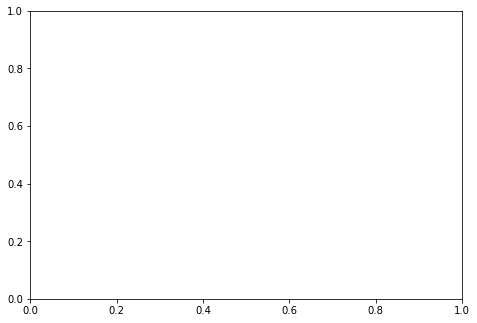

In [27]:
nx.draw(G)